<a href="https://colab.research.google.com/github/bsureshkrishna/qlsc600_2023/blob/main/lec2_sdt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, some book-keeping and importing

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import norm
from scipy.stats import skewnorm
from sklearn.metrics import auc
import math as math

Now let us consider an experiment where one half of trials contains the signal and the other half contains the noise, and what we get is a noisy measurement from the trial, that has some information about whether it was a signal trial or a noise trial. This situation is very general. For example (without paying attention to the relative proportions of signal and noise in these examples):



1.   An airport security operator sees a bag under the X-ray scanner and tries to determine if it contains a forbidden item or not.
2.   A radiologist sees an X-ray and tries to determine if there is a lesion in it or not.
3.   You hear a sound and try to determine if your name was called or not.
4.   You run a new test on a blood sample and try to determine if a certain condition is present or not.
5.   Come up with a few more.

We can, with many assumptions, model these situations in the simplest case in the following way. For now, let us assume that when the thing we are looking for is present, the response variable can take on a range of values, and when it is not, the response variable takes on another range.

To think about: What does it mean to say that the response variable contains information about the presence of the signal ?

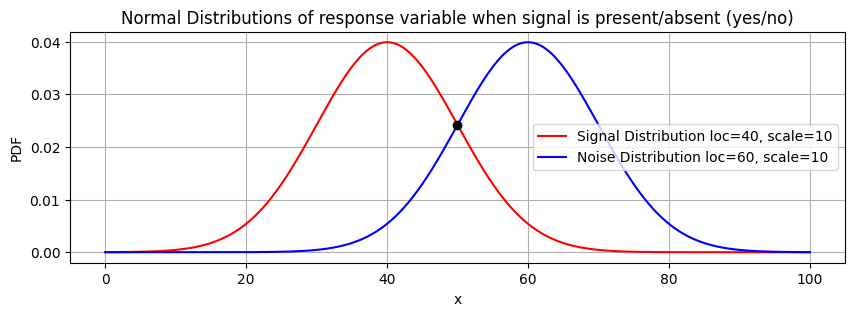

In [138]:
# Generate x values - the response variable takes values from 0 to 100 (arbitrary)
x = np.linspace(0, 100, 1000)
diff_x=np.linspace(-100,100,1000)

# Parameters for the normal distribution
loc1 = 40  # location parameter (mean)
scale1 = 10  # scale parameter (sd)
loc2 = 60  # location parameter (mean)
scale2 = 10  # scale parameter (sd)

# Compute the PDF values
pdf1 = norm.pdf(x, loc1, scale1)
pdf2 = norm.pdf(x, loc2, scale2)

# Plot the distributions
plt.figure(figsize=(10,3))
plt.plot(x, pdf1, label=f'Signal Distribution loc={loc1}, scale={scale1}',color='red')
plt.plot(x, pdf2, label=f'Noise Distribution loc={loc2}, scale={scale2}',color='blue')

idx = np.argwhere(np.diff(np.sign(pdf2 - pdf1))).flatten()
plt.plot(x[idx], pdf2[idx], 'ko')
intersect_point=x[idx]

plt.title("Normal Distributions of response variable when signal is present/absent (yes/no)")
plt.xlabel("x")
plt.ylabel("PDF")
plt.legend()
plt.grid(True)

plt.show()

One way to do this task is to set a value of a threshold. If the response variable is greater than this value, we say the signal is present, and if not, we say it is absent.

More generally, response variables can be multidimensional (in which case the acceptance region may also be multidimensional). The acceptance region can also be much more complex, even in 1 dimension, if the underlying response variable distributions are. Think about these..

But for now, let us consider the response variable distributions above, and then see what happens as the threshold is varied. Try to predict what happens when you use a very low threshold, a threshold at the intersection point, and a very high threshold..

Area Under the Curve (AUC): 0.9213


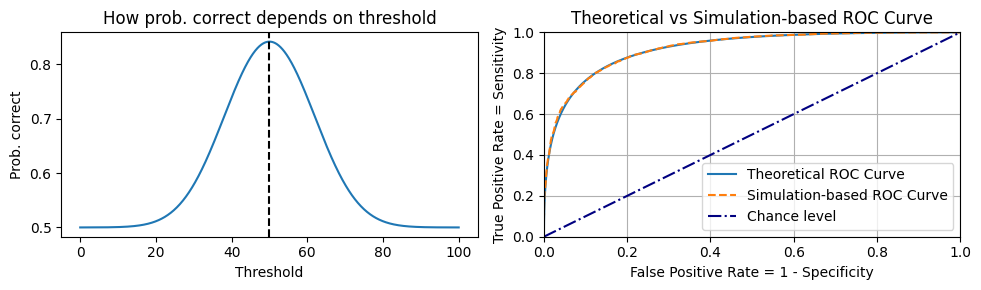

In [139]:
# Calculate theoretical ROC
fpr_theoretical = []
tpr_theoretical = []

thresholds = np.linspace(min(x), max(x), 1000)

for threshold in thresholds:
    tpr_theoretical.append(1 - norm.cdf(threshold, loc2, scale2))
    fpr_theoretical.append(1 - norm.cdf(threshold, loc1, scale1))

#calculating percentage correct, assuming 50 % of trials are signal (yes/no experiment)
percor_theoretical = 0.5*(np.array(tpr_theoretical) + (1 - np.array(fpr_theoretical)))

# Compute the AUC
roc_auc = auc(fpr_theoretical, tpr_theoretical)
print(f"Area Under the Curve (AUC): {roc_auc:.4f}")

# Simulate samples - for simulation-based roc
n_trials = 10000
n_half = n_trials // 2 #50 % of trials are signal and 50 % are noise

samples_noise = norm.rvs(loc1, scale1, size=n_half)
samples_signal = norm.rvs(loc2, scale2, size=n_half)

labels_noise = np.zeros(n_half)
labels_signal = np.ones(n_half)

samples = np.concatenate([samples_noise, samples_signal])
labels = np.concatenate([labels_noise, labels_signal])

# Calculate simulation-based ROC
fpr_simulation = [] #false-positive rate
tpr_simulation = [] #true-positive rate

for threshold in thresholds:
    predictions = samples > threshold
    tp = np.sum((predictions == 1)&(labels==1))
    fp = np.sum((predictions == 1)&(labels==0))
    tn = np.sum((predictions == 0)&(labels==0))
    fn = np.sum((predictions == 0)&(labels==1))

    tpr_simulation.append(tp / (tp + fn))
    fpr_simulation.append(fp / (fp + tn))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(thresholds, percor_theoretical)
plt.axvline(intersect_point,color='black',linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Prob. correct')
plt.title("How prob. correct depends on threshold")

# Second Column (for the ROC curves)
plt.subplot(1, 2, 2)
plt.plot(fpr_theoretical, tpr_theoretical, label='Theoretical ROC Curve')
plt.plot(fpr_simulation, tpr_simulation, label='Simulation-based ROC Curve', linestyle='--')
plt.plot([0, 1], [0, 1], color='navy', linestyle='-.', label='Chance level')
plt.xlabel('False Positive Rate = 1 - Specificity')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('Theoretical vs Simulation-based ROC Curve')
plt.legend()
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])

# Adjust the layout so plots don't overlap
plt.tight_layout()
plt.show()

The vertical line above in the left column is drawn at the intersection point of the two distributions from above.

Next, let us consider a different task, where on each trial, one gets two-samples,  one from the signal and one from the noise, and one has to determine which one is the one from the signal. An example would be a police line-up with only 1 "foil". Or searching for your friend in a crowd. Etc. Any situation where you know the signal is present, but do not know which of the samples has the signal. (Aside: The relationship of this situation to the one above is like the relationship of a two-sample t-test to a single sample t-test).

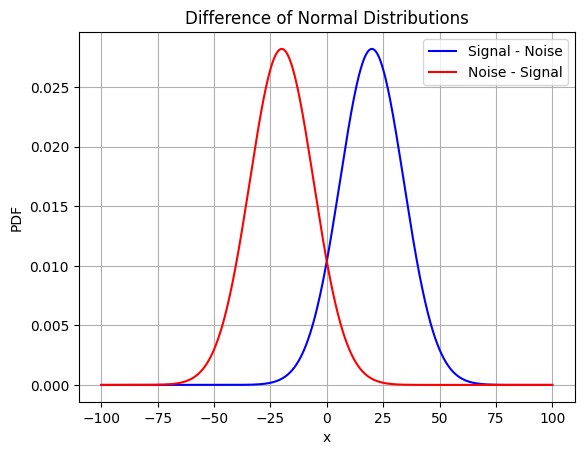

Prob. of being correct in 2-I, 2-AFC task: 0.9214


In [140]:
#Now consider a two-interval two-alternative forced choice task
#Each trial gives two samples,  and one has to decide which is signal and which is noise
#Let us look at the distribtion of the difference for (signal-noise) and for (noise-signal);
#the latter is just the distribution of -1 multiplied by the former

pdf_diff1=norm.pdf(diff_x,loc2-loc1,math.sqrt(scale1**2+scale2**2)) #variance of difference is sum of individual variances
pdf_diff2=norm.pdf(diff_x,loc1-loc2,math.sqrt(scale1**2+scale2**2))

plt.plot(diff_x, pdf_diff1,color='blue',label='Signal - Noise')
plt.plot(diff_x, pdf_diff2,color='red',label='Noise - Signal')

plt.title("Difference of Normal Distributions")
plt.xlabel("x")
plt.ylabel("PDF")
plt.legend()
plt.grid(True)
plt.show()

percentage_correct = 1 - norm.cdf(0, loc2-loc1,math.sqrt(scale1**2+scale2**2))
print(f"Prob. of being correct in 2-I, 2-AFC task: {percentage_correct:.4f}")

See how there is no threshold setting here, and no role of response caution. However, there are other confounds and biases, like order effects, tendency to prefer one or other sample etc.

That aside, the probability of being correct in a 2I, 2-AFC task in ideal scenarios is exactly equal to the area under the ROC curve drawn from the yes/no experiment. Compare the value printed below the graph above to the area under the ROC curve mentioned above. Vary the location and scale parameters of the distributions at the top and see how the plots and numbers change.

Next, let us consider a situation where the signal and noise samples do not have an equal chance of appearing on a given trial. For example, many more trials contain the noise sample than the signal sample. Outside of laboratory experiments, unequal proportions is likely much more common. Think of some examples.

For the well-behaved probability distributions, we are considering, the intersection point still locates the optimal threshold criterion. It is also where the sample value becomes more likely under the signal distribution than the noise distribution. However, this intersection is no longer at the midpoint between the two means.

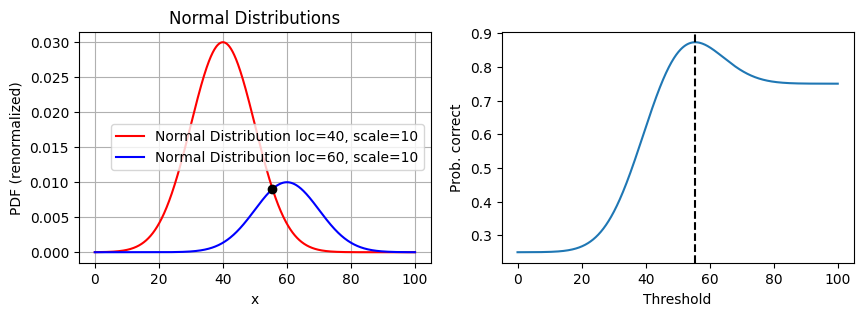

In [141]:
# Plot the distributions
plt.figure(figsize=(10,3))
pdf11=3*pdf1/4;
pdf22=1*pdf2/4;

#calculating percentage correct, assuming 50 % of trials are signal (yes/no experiment)
percor_theoretical = (np.array(tpr_theoretical) + 3*(1 - np.array(fpr_theoretical)))/4

plt.subplot(1, 2, 1)
plt.plot(x, pdf11, label=f'Normal Distribution loc={loc1}, scale={scale1}',color='red')
plt.plot(x, pdf22, label=f'Normal Distribution loc={loc2}, scale={scale2}',color='blue')

idx = np.argwhere(np.diff(np.sign(pdf22 - pdf11))).flatten()
plt.plot(x[idx], pdf22[idx], 'ko')
intersect_point=x[idx]

plt.title("Normal Distributions")
plt.xlabel("x")
plt.ylabel("PDF (renormalized)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thresholds,percor_theoretical)
plt.axvline(intersect_point,color='black',linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("Prob. correct")
plt.show()

Try to understand the plot on the right, and explain why the left and right end of this plot does not lie at 0.5 unlike the situation where the two trial types occurred equally often.

Finally, let us consider a little situation where the two response variable distributions are no longer normal, but in this case, skewed. See which of the properties from above are retained, and which ones are affected. In general, each set of distributions will require a fresh assessment, but there are certain regularities that are true for "well-behaved" distributions. Here, instead of normal distributions, we will use skew-normal distribtions, where the a parameter controls the skew direction and magnitude.

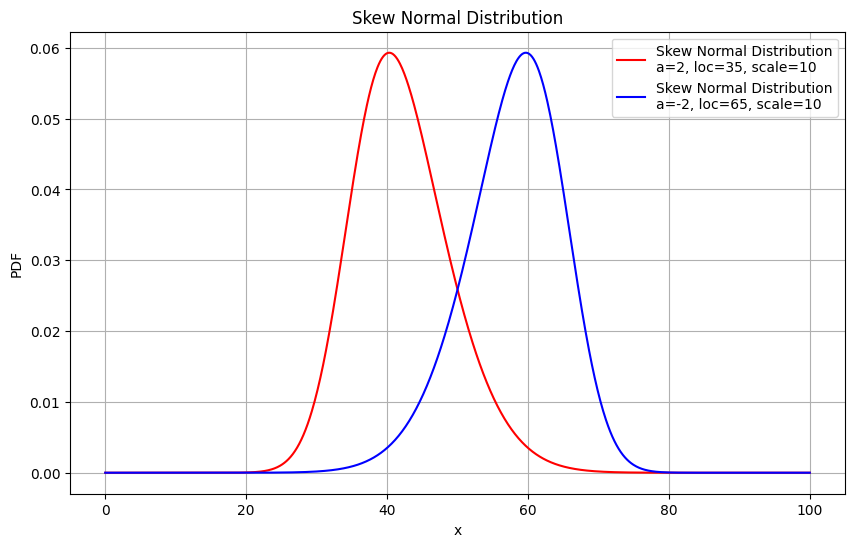

In [142]:
# Generate x values
x = np.linspace(0, 100, 1000)

# Parameters for the skew normal distribution
a1 = 2  # skewness parameter; positive values indicate right skew, negative values indicate left skew
loc1 = 35  # location parameter (similar to mean of normal)
scale1 = 10  # scale parameter (similar to standard deviation of normal)

a2 = -2  # skewness parameter; positive values indicate right skew, negative values indicate left skew
loc2 = 65  # location parameter (similar to mean of normal)
scale2 = 10  # scale parameter (similar to standard deviation of normal)

# Compute the PDF values
pdf1 = skewnorm.pdf(x, a1, loc1, scale1)
pdf2 = skewnorm.pdf(x, a2, loc2, scale2)

# Plot the skew normal distributions
plt.figure(figsize=(10, 6))
plt.plot(x, pdf1, label=f'Skew Normal Distribution\na={a1}, loc={loc1}, scale={scale1}',color='red')
plt.plot(x, pdf2, label=f'Skew Normal Distribution\na={a2}, loc={loc2}, scale={scale2}',color='blue')
plt.title("Skew Normal Distribution")
plt.xlabel("x")
plt.ylabel("PDF")
plt.legend()
plt.grid(True)
plt.show()


In [143]:
#Simulate a 2I, 2-AFC task
# The observer's task is to identify which sample came from the distribution with the higher mean (loc2)
# The observer is correct when the value from simulated_values2 is greater than the value from simulated_values1

numsamples=10000
#Simulate numsamples values from each of these
simulated_values1 = skewnorm.rvs(a1, loc1, scale1, size=numsamples)
simulated_values2 = skewnorm.rvs(a2, loc2, scale2, size=numsamples)

correct_choices = np.sum(simulated_values2 > simulated_values1)
percentage_correct = correct_choices / numsamples
print(f"Prob. correct based on the simulation: {percentage_correct:.4f}")

# Calculate theoretical ROC
fpr_theoretical = []
tpr_theoretical = []
thresholds = np.linspace(min(x), max(x), 1000)

for threshold in thresholds:
    tpr_theoretical.append(1 - skewnorm.cdf(threshold, a2, loc2, scale2))
    fpr_theoretical.append(1 - skewnorm.cdf(threshold, a1, loc1, scale1))

# Compute the AUC
roc_auc = auc(fpr_theoretical, tpr_theoretical)
print(f"Area Under the Curve (AUC): {roc_auc:.4f}")

Prob. correct based on the simulation: 0.9388
Area Under the Curve (AUC): 0.9355
